In [1]:
from LSTM_model import *
import torch
import pytreebank
import spacy
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

#Load GPU
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

#Load Data
train = pytreebank.import_tree_corpus("./sentiment/train.txt")
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

def seperate(dataset): #Use All nodes
    seperation = []
    for data in dataset:
        for label, text in data.to_labeled_lines():
            seperation.append((label,text))
    return seperation

train_sep = seperate(train)
text_pipeline = lambda x: vocab(tokenizer(x))

def yield_tokens(data_iter): #data_iter, e.g., train
    for _, text in data_iter: 
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_sep), specials=['<unk>','<pad>','<bos>','<eos>'], special_first = True)
vocab.set_default_index(vocab["<unk>"])
pad_ix = vocab['<pad>']

#hyper-parameter
input_dim  = len(vocab)
hid_dim    = 256
emb_dim    = 300         
output_dim = 5
num_layers = 2
bidirectional = True
dropout = 0.5

model = LSTM(input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout, pad_ix).to(device)
save_path = f'models/LSTM_TreeBank.pt'
model.load_state_dict(torch.load(save_path))

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

In [2]:
# reddit crawler
import praw
your_client_id='ElyKc6o3du1IMb5LP2HYjg'
your_client_secret='YimfVn3bTLyVFu_XkJuLxrNkR3vHAQ'
your_user_name='guntsv'

reddit = praw.Reddit(client_id=your_client_id,
                     client_secret=your_client_secret,
                     user_agent=your_user_name,
                     check_for_async=False)

In [3]:
subreddit = reddit.subreddit('bitcoin')
topics = [*subreddit.top(limit=None)] # top posts all time
print(len(topics))

992


In [4]:
for topic in topics:
    print(topic.title) # headline
    break

It's official! 1 Bitcoin = $10,000 USD


In [5]:
import pandas as pd

title = [n.title for n in topics]
df_topics = pd.DataFrame({"title": title})
df_topics.head()

,title
0,"It's official! 1 Bitcoin = $10,000 USD"
1,The last 3 months in 47 seconds.
2,Tesla buys $1.5b in Bitcoin and is looking to ...
3,It's over 9000!!!
4,Everyone who's trading BTC right now


In [6]:
df_topics.shape

(992, 1)

In [7]:
def prediction(test_str_list):
    result = list()
    for test_str in test_str_list:
        text = torch.tensor(text_pipeline(test_str)).to(device).reshape(1, -1)
        # text_list = [x.item() for x in text]
        text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1].detach().cpu().numpy()[0]
        result.append((test_str, predicted))
    return result

In [8]:
result = pd.DataFrame(prediction(df_topics['title']))
result = result.rename(columns={0: 'Title', 1: 'Rating'})
result.head()

,Title,Rating
0,"It's official! 1 Bitcoin = $10,000 USD",2
1,The last 3 months in 47 seconds.,1
2,Tesla buys $1.5b in Bitcoin and is looking to ...,3
3,It's over 9000!!!,3
4,Everyone who's trading BTC right now,2


In [9]:
result['Rating'].value_counts()

2    493
1    308
3    157
4     22
0     12
Name: Rating, dtype: int64

<AxesSubplot: >

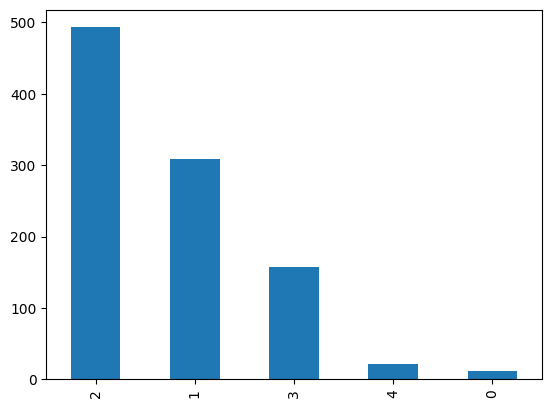

In [11]:
result['Rating'].value_counts().plot(kind='bar')

## Reference
- https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/
- https://medium.com/bitgrit-data-science-publication/sentiment-analysis-on-reddit-tech-news-with-python-cbaddb8e9bb6